UPLOAD DO ARQUIVO DE AUDIO

In [ ]:
from google.colab import files
import io
from IPython.display import Audio, display

In [ ]:
print("Por favor, faça o upload do seu arquivo de áudio 'minha_voz.wav'")
uploaded = files.upload()

Por favor, faça o upload do seu arquivo de áudio 'minha_voz.wav'


Saving voz_original.wav to voz_original (1).wav


In [ ]:
file_name = next(iter(uploaded))
print(f"Arquivo '{file_name}' carregado com sucesso!")

Arquivo 'voz_original (1).wav' carregado com sucesso!


CARREGAR AUDIO E DEFINIR PARAMETROS




In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
# Carrega o áudio do arquivo enviado
fs, v_raw = wavfile.read(io.BytesIO(uploaded[file_name]))

# Converte para float e normaliza para o intervalo [-1, 1]


# Verifica se o áudio tem mais de um canal (estéreo)
if v_raw.ndim > 1 and v_raw.shape[1] > 1:
    print("Áudio estéreo detectado. Selecionando apenas o primeiro canal.")
    # Seleciona TODAS as amostras (:) da PRIMEIRA coluna (0)
    v_mono = v_raw[:, 0]
else:
    print("Áudio já é mono.")
    v_mono = v_raw

v = v_mono.astype(np.float64)
v = v / np.max(np.abs(v))
print(f"Áudio carregado com frequência de amostragem: {fs} Hz")

Áudio já é mono.
Áudio carregado com frequência de amostragem: 44100 Hz


In [ ]:
duration = len(v) / fs

#Parâmetros 4
f1 = 5200.0
f2 = 5500.0
delta2 = 0.001


ADICIONAR RUIDO



In [ ]:
n_samples = len(v)
t = np.linspace(0, duration, n_samples, endpoint=False)

In [ ]:
# Gera o sinal de ruído r(t) = a1*cos(2*pi*f1*t) + a2*cos(2*pi*f2*t)
a1, a2 = 0.15, 0.15
r = a1 * np.cos(2 * np.pi * f1 * t) + a2 * np.cos(2 * np.pi * f2 * t)
z = v + r

print("Ruído adicionado ao sinal de voz.")

Ruído adicionado ao sinal de voz.


In [ ]:
z_clipped = np.clip(z, -1, 1)

# 2. Conversão para int16: Escala o sinal float para o intervalo de int16
#    np.iinfo(np.int16).max retorna o valor máximo para int16 (32767)
z_int = (z_clipped * np.iinfo(np.int16).max).astype(np.int16)

# 3. Salva o arquivo .wav
output_filename = "minha_voz_corrompida.wav"
wavfile.write(output_filename, fs, z_int)

print(f"\nÁudio com ruído foi salvo com sucesso no arquivo: '{output_filename}'")


Áudio com ruído foi salvo com sucesso no arquivo: 'minha_voz_corrompida.wav'


FILTRO IIR

In [ ]:
fn = fs / 2.0
wp = [5000, 5700]
ws = [5100, 5600]

gpass = 1.0
gstop = 20 * np.log10(delta2)
n, wn = signal.buttord(wp, ws, gpass, abs(gstop), fs=fs)

In [ ]:
# Obtém os coeficientes no formato SOS (Second-Order Sections)
sos = signal.butter(n, wn, btype='bandstop', analog=False, output='sos', fs=fs)

print("Filtro IIR projetado com sucesso usando formato SOS (mais estável).")

# Aplica o filtro H(z) usando a função sosfilt, própria para esse formato
y = signal.sosfilt(sos, z)

Filtro IIR projetado com sucesso usando formato SOS (mais estável).


In [ ]:
y_clipped = np.clip(y, -1, 1)

# 2. Conversão para int16: Escala o sinal para o intervalo de inteiros de 16 bits.
y_int = (y_clipped * np.iinfo(np.int16).max).astype(np.int16)

# 3. Salva o arquivo .wav final.
output_filename = "minha_voz_filtrada.wav"
wavfile.write(output_filename, fs, y_int)

print(f"\nÁudio filtrado foi salvo com sucesso no arquivo: '{output_filename}'")


Áudio filtrado foi salvo com sucesso no arquivo: 'minha_voz_filtrada.wav'


GERAR GRAFICOS

Gráficos no Domínio do Tempo

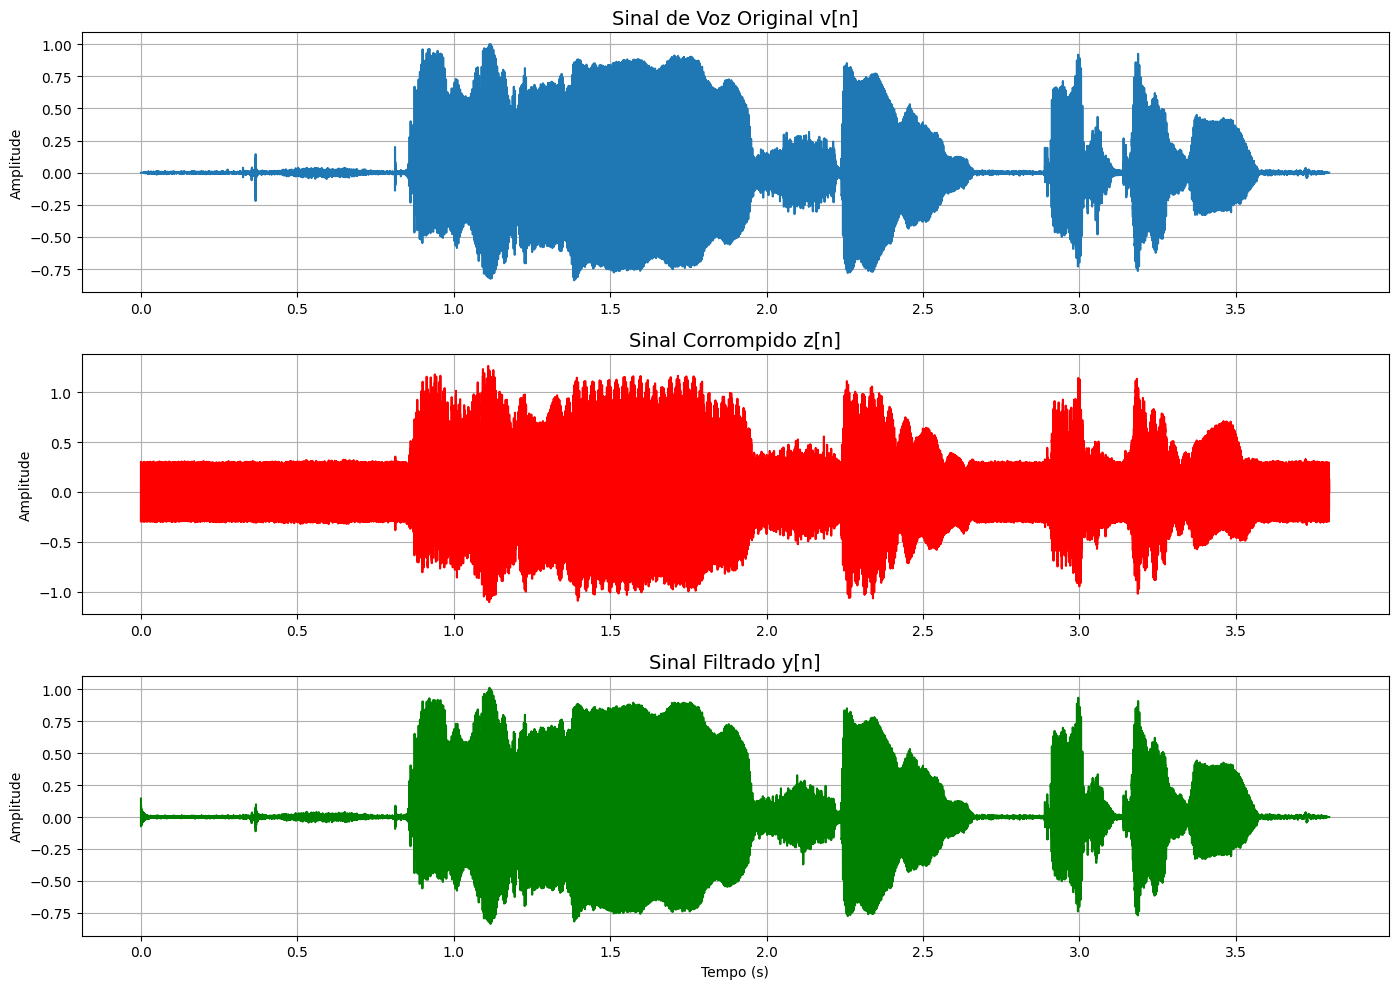

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(t, v)
plt.title('Sinal de Voz Original v[n]', fontsize=14)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(3, 1, 2)
plt.plot(t, z, color='r')
plt.title('Sinal Corrompido z[n]', fontsize=14)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(3, 1, 3)
plt.plot(t, y, color='g')
plt.title('Sinal Filtrado y[n]', fontsize=14)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

DOMINIO FREQUENCIA


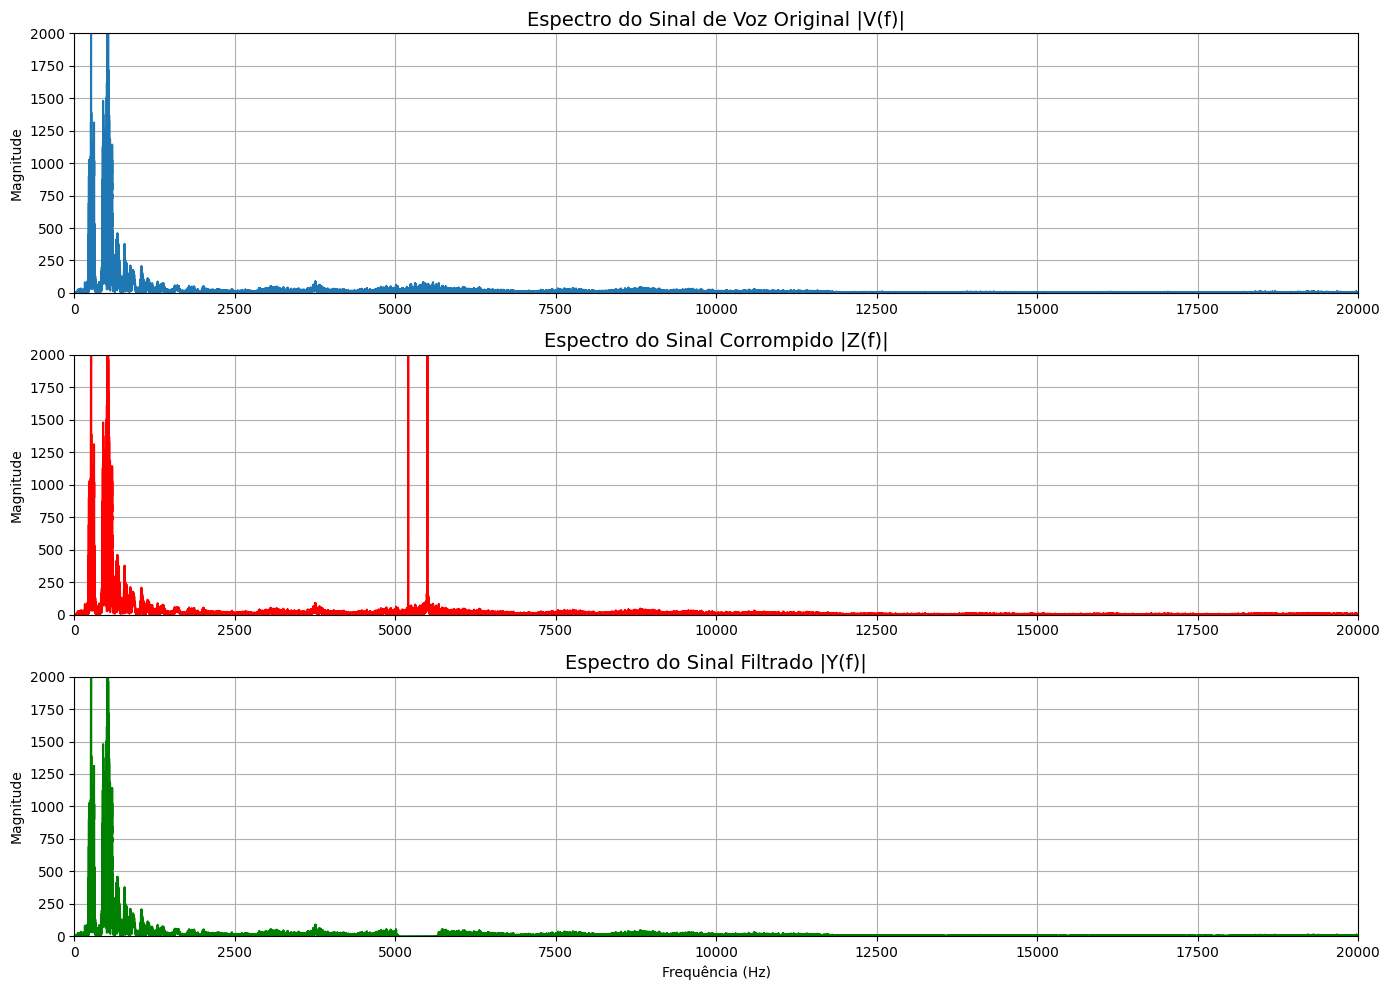

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq



# Número de amostras em cada sinal
N = len(v)

# --- Cálculo da FFT para cada sinal ---

# 1. Sinal Original (v)
# Calcula a FFT e o eixo de frequências
yf_v = fft(v)
xf = fftfreq(N, 1 / fs)
# Pega apenas as frequências positivas e suas magnitudes
xf_v_pos = xf[:N//2]
yf_v_mag = np.abs(yf_v[:N//2])

# 2. Sinal Corrompido (z)
yf_z = fft(z)
xf_z_pos = xf[:N//2] # O eixo de frequência é o mesmo
yf_z_mag = np.abs(yf_z[:N//2])

# 3. Sinal Filtrado (y)
yf_y = fft(y)
xf_y_pos = xf[:N//2] # O eixo de frequência é o mesmo
yf_y_mag = np.abs(yf_y[:N//2])


# --- Plotando os espectros ---
plt.figure(figsize=(14, 10))

# Gráfico 1: Espectro do Sinal Original
plt.subplot(3, 1, 1)
plt.plot(xf_v_pos, yf_v_mag)
plt.title('Espectro do Sinal de Voz Original |V(f)|', fontsize=14)
plt.ylabel('Magnitude')
plt.ylim(0,2000)
plt.grid(True)
# Vamos focar na região onde o ruído será adicionado para melhor visualização
plt.xlim(0, 20_000)

# Gráfico 2: Espectro do Sinal Corrompido
plt.subplot(3, 1, 2)
plt.plot(xf_z_pos, yf_z_mag, color='r')
plt.title('Espectro do Sinal Corrompido |Z(f)|', fontsize=14)
plt.ylabel('Magnitude')
plt.ylim(0,2000)
plt.grid(True)
plt.xlim(0, 20_000)

# Gráfico 3: Espectro do Sinal Filtrado
plt.subplot(3, 1, 3)
plt.plot(xf_y_pos, yf_y_mag, color='g')
plt.title('Espectro do Sinal Filtrado |Y(f)|', fontsize=14)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0,2000)
plt.grid(True)
plt.xlim(0, 20_000)

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Resposta em Frequência do Filtro

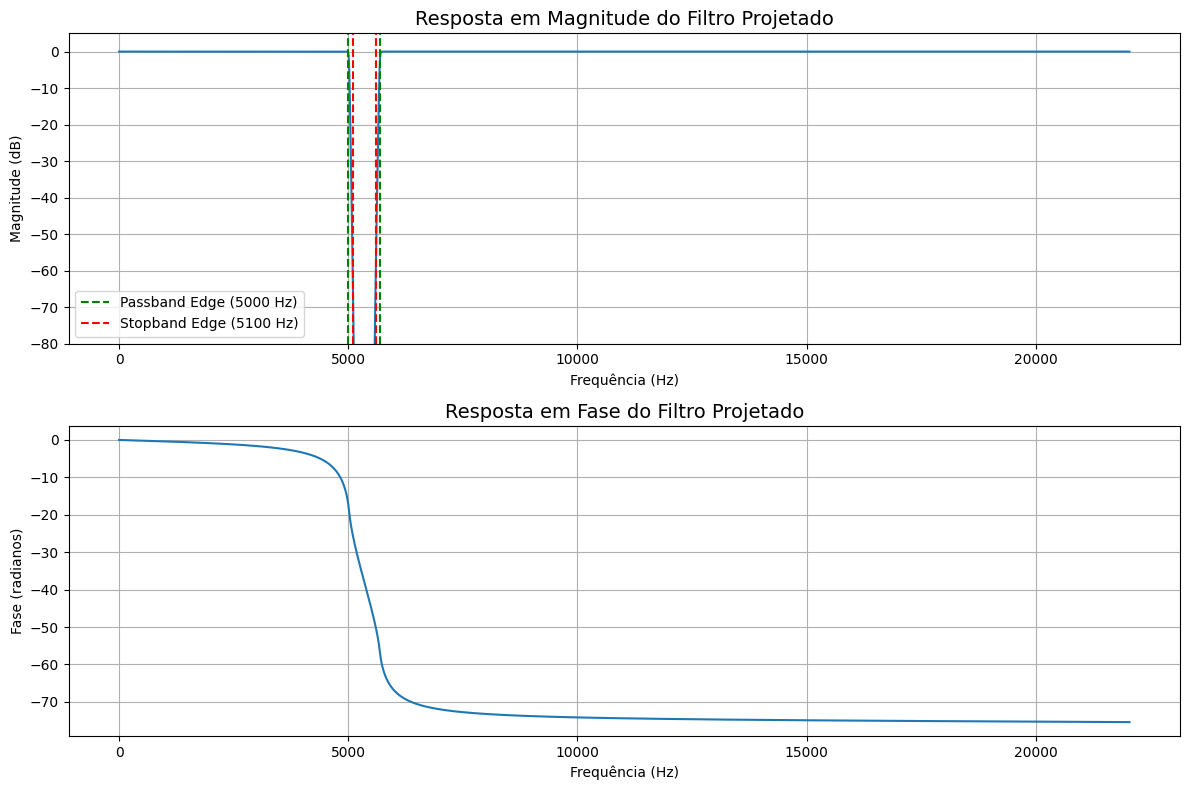

In [ ]:
w_hz, h = signal.sosfreqz(sos, worN=8000, fs=fs)

plt.figure(figsize=(12, 8))

# Gráfico de Magnitude
plt.subplot(2, 1, 1)
plt.plot(w_hz, 20 * np.log10(np.abs(h)))
plt.title('Resposta em Magnitude do Filtro Projetado', fontsize=14)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.axvline(wp[0], color='g', linestyle='--', label=f'Passband Edge ({wp[0]} Hz)')
plt.axvline(wp[1], color='g', linestyle='--')
plt.axvline(ws[0], color='r', linestyle='--', label=f'Stopband Edge ({ws[0]} Hz)')
plt.axvline(ws[1], color='r', linestyle='--')
plt.ylim(-80, 5)
plt.grid(True)
plt.legend()

# Gráfico de Fase
plt.subplot(2, 1, 2)
# np.unwrap remove saltos de 2*pi da fase para um gráfico mais limpo
plt.plot(w_hz, np.unwrap(np.angle(h)))
plt.title('Resposta em Fase do Filtro Projetado', fontsize=14)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (radianos)')
plt.grid(True)

plt.tight_layout()
plt.show()

AUDIOS


In [ ]:
output_filename_filtrado = 'voz_original.wav' # Caminho para o arquivo salvo
print('\nReproduzindo o áudio filtrado:')
display(Audio(output_filename_filtrado))


Reproduzindo o áudio filtrado:


In [ ]:
output_filename_filtrado = 'minha_voz_corrompida.wav' # Caminho para o arquivo salvo
print('\nReproduzindo o áudio filtrado:')
display(Audio(output_filename_filtrado))


Reproduzindo o áudio filtrado:


In [ ]:
output_filename_filtrado = 'minha_voz_filtrada.wav' # Caminho para o arquivo salvo
print('\nReproduzindo o áudio filtrado:')
display(Audio(output_filename_filtrado))


Reproduzindo o áudio filtrado:
